In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker


from sklearn.cluster import KMeans
from sklearn.exceptions import ConvergenceWarning
from sklearn.decomposition import PCA

In [2]:
#importing data 
df = pd.read_csv('sales_data_sample.csv', sep = ',', encoding='Latin-1')
#checking the datetype
df.dtypes

ORDERNUMBER           int64
QUANTITYORDERED       int64
PRICEEACH           float64
ORDERLINENUMBER       int64
SALES               float64
ORDERDATE            object
STATUS               object
QTR_ID                int64
MONTH_ID              int64
YEAR_ID               int64
PRODUCTLINE          object
MSRP                  int64
PRODUCTCODE          object
CUSTOMERNAME         object
PHONE                object
ADDRESSLINE1         object
ADDRESSLINE2         object
CITY                 object
STATE                object
POSTALCODE           object
COUNTRY              object
TERRITORY            object
CONTACTLASTNAME      object
CONTACTFIRSTNAME     object
DEALSIZE             object
dtype: object

In [3]:
df.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


# -----------------

## Data Cleaning

In [4]:
#deleting data that are not necessary for the analysis 
df.drop(["ORDERLINENUMBER", "MSRP", "PRODUCTCODE", "PHONE", "ADDRESSLINE1", "ADDRESSLINE2", "STATE", "POSTALCODE", "TERRITORY"], axis = 1, inplace = True)

In [5]:
#check for null values 
nan_df = df[df.isna().any(axis=1)]    
len(nan_df)

0

# -----------------

## Brief EDA 

In [6]:
#unique status
df['STATUS'].unique()

array(['Shipped', 'Disputed', 'In Process', 'Cancelled', 'On Hold',
       'Resolved'], dtype=object)

In [7]:
#uniqute productline 
df['PRODUCTLINE'].unique()

array(['Motorcycles', 'Classic Cars', 'Trucks and Buses', 'Vintage Cars',
       'Planes', 'Ships', 'Trains'], dtype=object)

In [8]:
#unique sizes 
df['DEALSIZE'].unique()

array(['Small', 'Medium', 'Large'], dtype=object)

In [9]:
#orders have been shipped in these countries 
country_list = df['COUNTRY'].unique()
country_list

array(['USA', 'France', 'Norway', 'Australia', 'Finland', 'Austria', 'UK',
       'Spain', 'Sweden', 'Singapore', 'Canada', 'Japan', 'Italy',
       'Denmark', 'Belgium', 'Philippines', 'Germany', 'Switzerland',
       'Ireland'], dtype=object)

In [10]:
#total number of countries where orders have been shipped
len(country_list)

19

In [11]:
#timeline of the orders 
df['YEAR_ID'].unique()

array([2003, 2004, 2005])

In [12]:
#checking the timeline of the dataset
df.groupby(['YEAR_ID']).nunique()['MONTH_ID']

YEAR_ID
2003    12
2004    12
2005     5
Name: MONTH_ID, dtype: int64

Conclustion: 

1. The dataset consists of 25 variables and 2 823 rows, providing detailed information about each order, including its price, quantity, status, product line, order date, and customer details such as names, addresses, and countries.

2. The dataset spans a period of three years, covering full years for 2003 and 2004, as well as the first five months of 2005. 

3. Every order has a variable  “STATUS”. It includes 6 unique values, such as 'Shipped', 'Disputed', 'In Process', 'Cancelled', 'On Hold', 'Resolved'

4. Company has 7 unique product lines: 'Motorcycles', 'Classic Cars', 'Trucks and Buses', 'Vintage Cars', 'Planes', 'Ships', 'Trains’. 

5. The company has  delivered products to 19 countries worldwide, including locations across North America, Eurasia, and Australia.

# -----------------

## KPIs construction 

Based on available data these KPIs will be used: 

* Total Sales  

* Total Sales (Shipped only)  

* Sales diff (%) -  relative difference between total sales and total sales (shipped only) 

* Total quantity 

* Total quantity (Shipped only)  

* Quantity diff (%) - relative difference between total quantity and total quantity  (shipped only) 

* Average price per unit - total sales divided by total quantity 

* Number of orders 

* Level of successful delivery (%) - ratio of shipped orders by all orders

* Cancelled orders (%) - ratio of cancelled orders by all orders 

Other measures: 

* Sales by product line 

* Sales by country 

* Sales by region 

* Sales by dealsize 

The function **total** calculates the overall amount of sales or total quantity based on specific parameters such as Year, Status, Product line, Country, and Deal Size.

The function **table_MainKPIs** returns a table containing predefined KPIs. It offers the flexibility to specify a particular year (using the parameter *year_kpi*) for the calculation of KPIs. 

The function **sales_by** retunrs a table that aggregates total sales based on a specific category. 

* The category is defined by the parametr *by* 
* The year is defined by the *year* 
* Additionally, the *rel* parametr, which takes a Boolean value, determines whether a column indicating the percentage of the total should be added to the table 

Function **perf_trans** takes two tables with the same structure and compare them YoY (absolute and relative) creating new columns. 

* current: this parameter refers to the table containing values for the current year
* previous: this parameter refers to the table with values for the year (year - N), where N signifies a specified number of years (in most cases it is year - 1)
* col: this parameter indicates the name of the column containing KPI names.


Function **format_thousands** is a formating function which will be used in graphs for better vizualization (i.e. 100 000 will be shown as 100K)

In [13]:
# function for total sales/quantity 

def total(data,type = "sales", year = None, status = None, product_line = None, country = None, dealsize = None):
     
    #filtering data  
    if year is not None: 
        data = data[data["YEAR_ID"]== year]
    
    if status is not None:
        data = data[data["STATUS"] == status]
    
    if product_line is not None:
        data = data[data["PRODUCTLINE"] == product_line]
        
    if country is not None:
        data = data[data["COUNTRY"] == country]
        
    if dealsize is not None: 
        data = data[data["DEALSIZE"] == dealsize]
    
        
    total_sales = data[type.upper()].sum()
    
    return total_sales


In [14]:
def table_MainKPIs(data, year_kpi = None):
    
    #definition if KPIs names
    KPIs_names =  ["Total Sales", "Total Sales(shipped)", "Sales diff(%)", "Total quantity", "Total quantity(shipped)", 
                   "Quantity diff(%)","Average price per unit", "Number of orders", "Level of successful delivery (%)","Cancelled orders(%)"]
    
    #total sales
    total_sales = total(data, year = year_kpi)

    #total sales (shipped)
    total_sales_shipped = total(data,year = year_kpi, status = "Shipped")

    #difference between shipped and all (%)
    dif_sales = round((total_sales - total_sales_shipped)/total_sales_shipped * 100,2)

    #total quantity
    total_quantity = total(data,year = year_kpi, type="quantityordered") 

    #total quantity (shipped)
    total_quantity_shipped = total(data,year = year_kpi, type="quantityordered",status = "Shipped")

    #difference between shipped and all (%)
    dif_quantity = round((total_quantity - total_quantity_shipped)/total_quantity_shipped * 100,2)
    
    #average price per unit 
    av_price = round(total_sales/total_quantity,2)
    
    if year_kpi is None:
        #Level of successful delivery(%)
        delivery_success = round(len(data[data["STATUS"] == "Shipped"])/len(data)*100,2)
        #count of orders 
        count_ordes = len(data)
        #cancelled orders (%)
        can_order = round(len(data[data["STATUS"] == "Cancelled"])/len(data)*100,2)
    else: 
        #Level of successful delivery(%)
        top = data[(data["STATUS"] == "Shipped") & (data["YEAR_ID"] == year_kpi)]
        bottom = data[data["YEAR_ID"] == year_kpi]
        delivery_success = round(len(top)/len(bottom)*100,2)
        
        #count of orders 
        count_ordes = len(bottom)
        
        #cancelled orders (%)
        can_order = round(len(data[(data["STATUS"] == "Cancelled") & (data["YEAR_ID"] == year_kpi)])/len(bottom)*100,2)
            
    KPIs_values = [total_sales,total_sales_shipped,dif_sales,total_quantity,total_quantity_shipped,
                   dif_quantity,av_price,count_ordes,delivery_success, can_order]           
    
    if year_kpi is None:
        name_tab = "KPI value"
    else: name_tab = "KPI value (" + str(year_kpi) + ")"            
        
    Main_KPIs = pd.DataFrame({
        "KPI NAME": KPIs_names,
        name_tab.upper() : KPIs_values 
        })
    
    return(Main_KPIs)

In [15]:
def sales_by(data,by, year = None, rel = True):
    
    if year is not None:
        data = data[data["YEAR_ID"]== year]
        df_sales_by = data.groupby([by.upper()]).sum()["SALES"].to_frame(name = "SALES").reset_index().sort_values(by = "SALES", ascending=False).reset_index(drop = True)
        tab_name = "Sales(" + str(year) + ")" 
        df_sales_by = df_sales_by.rename(columns = {"SALES":tab_name})
        if rel:
            #calculating percentage filed
            df_sales_by["PERCENTAGE"] = round(df_sales_by[tab_name] / sum(data["SALES"]) * 100,2)
        
    
    else: 
        df_sales_by = data.groupby([by.upper()]).sum()["SALES"].to_frame(name = "SALES").reset_index().sort_values(by = "SALES", ascending=False).reset_index(drop = True)    
        if rel:
            #calculating percentage filed
            df_sales_by["PERCENTAGE"] = round(df_sales_by["SALES"] / sum(data["SALES"]) * 100,2)
  

    return df_sales_by

In [16]:
def perf_trans(current, previous, col):
    #merging two tables 
    Performance = current.merge(previous, on=col.upper(), how='left').drop_duplicates()
    
    #calculating differences 
    Performance["Var absolute"] = Performance.iloc[:, 1] - Performance.iloc[:, 2]
    Performance["Var relative(%)"] = round((Performance.iloc[:, 1] - Performance.iloc[:, 2])/Performance.iloc[:, 2]*100,2)
    
    return Performance

In [17]:
def format_thousands(x, pos):
    return f'{x/1000:.0f}K'

# -----------------

## KPIs calculation and Company Overview

In [18]:
# example of function for total 
round(total(df,year = 2003, status = "Shipped", product_line = "Ships", country = "USA", dealsize = "Small"),2)

25921.01

In [19]:
#main KPIs
table_MainKPIs(df)

,KPI NAME,KPI VALUE
0,Total Sales,10032628.85
1,Total Sales(shipped),9291501.08
2,Sales diff(%),7.98
3,Total quantity,99067.00
4,Total quantity(shipped),91403.00
5,Quantity diff(%),8.38
6,Average price per unit,101.27
7,Number of orders,2823.00
8,Level of successful delivery (%),92.70
9,Cancelled orders(%),2.13


In [20]:
#sales by productline
sales_productline = sales_by(df, by = "productline") 
sales_productline

,PRODUCTLINE,SALES,PERCENTAGE
0,Classic Cars,3919615.66,39.07
1,Vintage Cars,1903150.84,18.97
2,Motorcycles,1166388.34,11.63
3,Trucks and Buses,1127789.84,11.24
4,Planes,975003.57,9.72
5,Ships,714437.13,7.12
6,Trains,226243.47,2.26


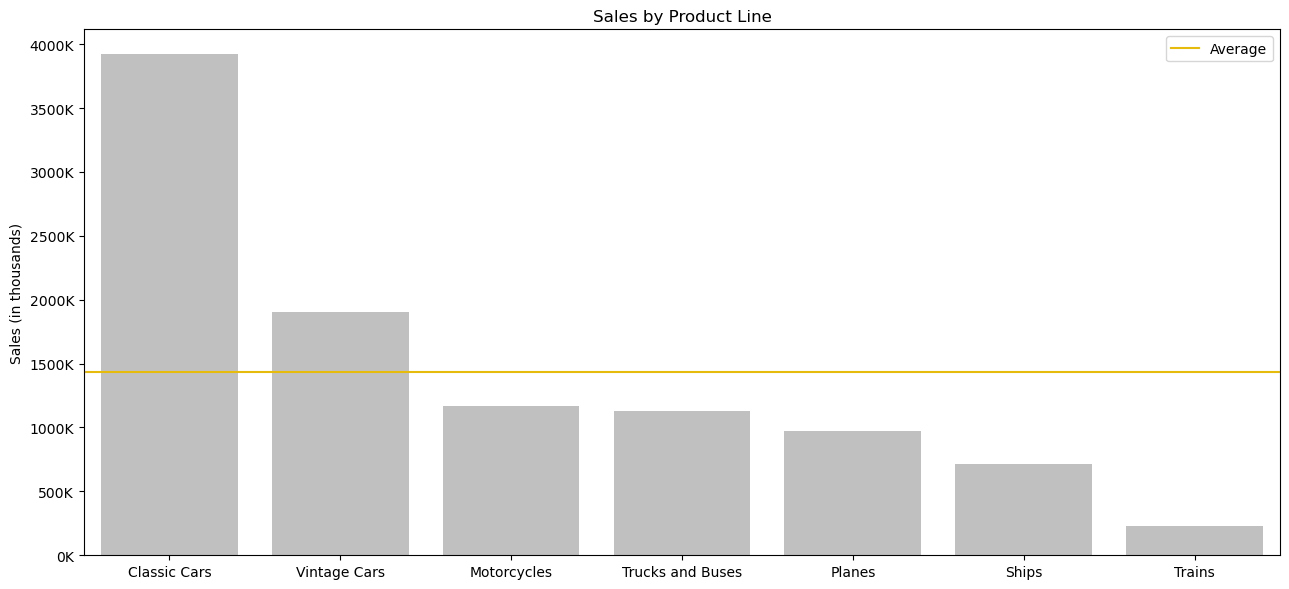

In [21]:
#graph sales by product line 

plt.figure(figsize=(13, 6))

sns.barplot(x="PRODUCTLINE", y="SALES", data=sales_productline,  color="silver")
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_thousands))
plt.xlabel("")
plt.ylabel("Sales (in thousands)")
plt.title("Sales by Product Line")
plt.tight_layout()

#average line
average_sales = sales_productline["SALES"].mean()
plt.axhline(average_sales, color='#E7BB0B', label='Average')
plt.legend()

plt.show()

In [22]:
#sales by deal size
sales_by_dealsize = sales_by(df,by = "dealsize")

sales_by_dealsize['DEALSIZE'] = sales_by_dealsize['DEALSIZE'].astype('category')
sales_by_dealsize['DEALSIZE'].cat.reorder_categories(['Small', 'Medium', 'Large'])

sales_by_dealsize

,DEALSIZE,SALES,PERCENTAGE
0,Medium,6087432.24,60.68
1,Small,2643077.35,26.34
2,Large,1302119.26,12.98


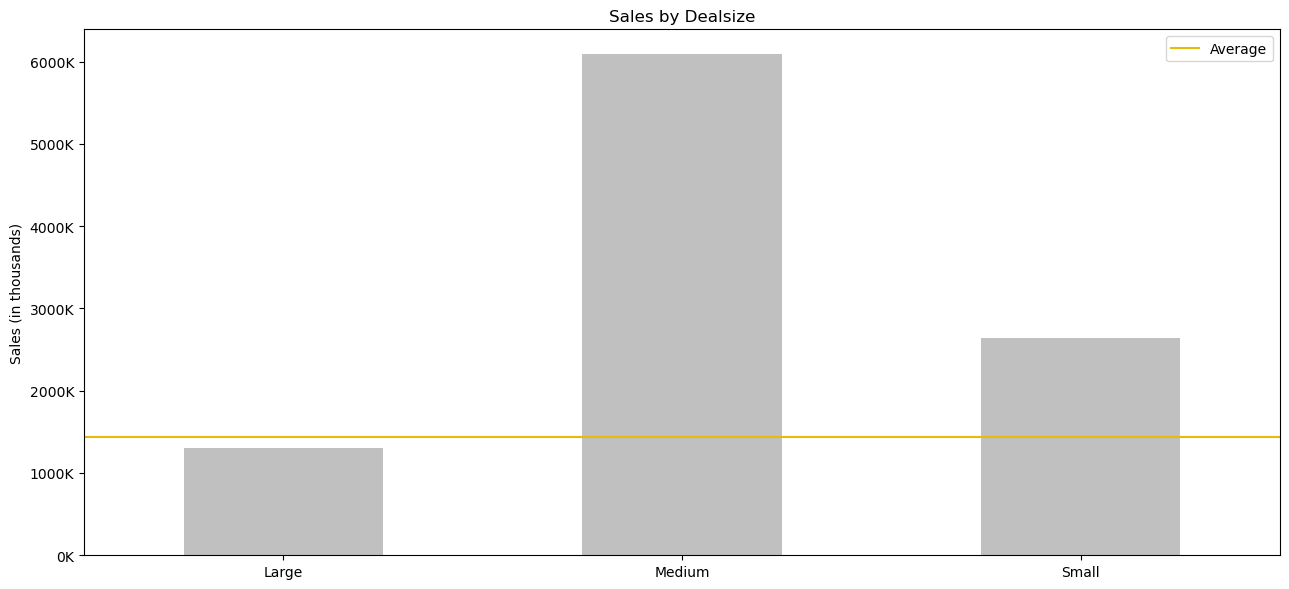

In [23]:
#plot sales by dealsize 

bar_width = 0.5

plt.figure(figsize=(13, 6))
sns.barplot(x="DEALSIZE", y="SALES", data=sales_by_dealsize,  color="silver", width=bar_width)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_thousands))
plt.xlabel("")
plt.ylabel("Sales (in thousands)")
plt.title("Sales by Dealsize")
plt.tight_layout()

#average line
average_sales = sales_productline["SALES"].mean()
plt.axhline(average_sales, color='#E7BB0B', label='Average')
plt.legend()

plt.show()

In [24]:
#sales by country 
df_sales_by_country = sales_by(df,by = "country")
df_sales_by_country

,COUNTRY,SALES,PERCENTAGE
0,USA,3627982.83,36.16
1,Spain,1215686.92,12.12
2,France,1110916.52,11.07
3,Australia,630623.10,6.29
4,UK,478880.46,4.77
5,Italy,374674.31,3.73
6,Finland,329581.91,3.29
7,Norway,307463.70,3.06
8,Singapore,288488.41,2.88
9,Denmark,245637.15,2.45


In [25]:
#plotting graph with average bar 1 

average_sales = round(df_sales_by_country["SALES"].mean(),2)
df_sales_by_country.loc["19"] = ["Average",average_sales,0 ]
df_sales_by_country = df_sales_by_country.sort_values(by="SALES",ascending = False)


df_sales_by_country["is_averg"] = np.where(df_sales_by_country["COUNTRY"] == "Average", 1, 0)

df_sales_by_country

,COUNTRY,SALES,PERCENTAGE,is_averg
0,USA,3627982.83,36.16,0
1,Spain,1215686.92,12.12,0
2,France,1110916.52,11.07,0
3,Australia,630623.10,6.29,0
19,Average,528033.10,0.00,1
4,UK,478880.46,4.77,0
5,Italy,374674.31,3.73,0
6,Finland,329581.91,3.29,0
7,Norway,307463.70,3.06,0
8,Singapore,288488.41,2.88,0


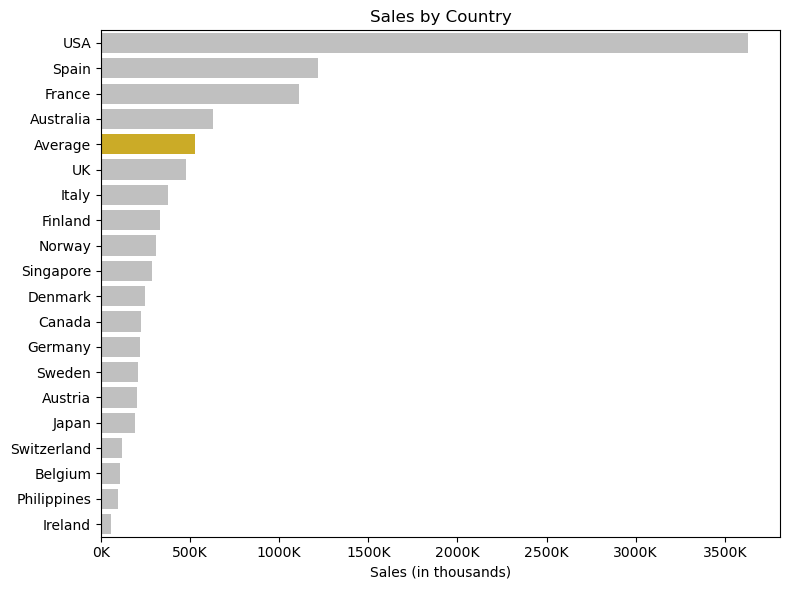

In [26]:
#plotting graph with average bar 1 

custom_palette = {True: '#E7BB0B', False: "silver"}

#building a plot 
plt.figure(figsize=(8, 6))
sns.barplot(y="COUNTRY", x="SALES", data=df_sales_by_country, hue="is_averg", palette=custom_palette, dodge=False)

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_thousands))
plt.xlabel("Sales (in thousands)")
plt.ylabel("")
plt.title("Sales by Country")
plt.tight_layout()
plt.legend().set_visible(False)

plt.show()


In [27]:
#cumulative sum of percentage for sales by country 
df_sales_by_country["CUMULAT_PERCETGAE"] = df_sales_by_country['PERCENTAGE'].cumsum()
df_sales_by_country

,COUNTRY,SALES,PERCENTAGE,is_averg,CUMULAT_PERCETGAE
0,USA,3627982.83,36.16,0,36.16
1,Spain,1215686.92,12.12,0,48.28
2,France,1110916.52,11.07,0,59.35
3,Australia,630623.10,6.29,0,65.64
19,Average,528033.10,0.00,1,65.64
4,UK,478880.46,4.77,0,70.41
5,Italy,374674.31,3.73,0,74.14
6,Finland,329581.91,3.29,0,77.43
7,Norway,307463.70,3.06,0,80.49
8,Singapore,288488.41,2.88,0,83.37


Regions definition : 

For better understanding the regional structure of the sales, grouping by two region will be introduced. 

* Region 1 - a wider grouping which contains North American continent, Asia and Australia combined (as for now counties in this region represent small percentage of sales) and Europe divided by geographical subregions 

* Region 2 - more specific grouping, where Europe is taken as a one subregion 


In [28]:
#definding regions 1 
continent_region2_mapping = {
    "North America": ["USA", "Canada"],  
    "Central Europe": ["France", "Germany","Austria","Switzerland","Belgium",],
    "Southern Europe": ["Spain","Italy"],
    "Northern Europe": ["UK","Finland","Norway","Denmark","Sweden","Ireland"],
    "Asia/Australia": ["Australia","Singapore","Japan","Philippines"]
}

#Create region based on the mapping dictionary
df["REGION1"] = df["COUNTRY"].map(
    lambda country: next(
        (region for region, countries in continent_region2_mapping.items() if country in countries), None
    )
)

In [29]:
df_sales_by_region1 = sales_by(df,by = "region1")
df_sales_by_region1

,REGION1,SALES,PERCENTAGE
0,North America,3852061.39,38.40
1,Central Europe,1759577.32,17.54
2,Northern Europe,1629333.86,16.24
3,Southern Europe,1590361.23,15.85
4,Asia/Australia,1201295.05,11.97


In [30]:
#defining regions 2 
continent_region1_mapping = {
    "North America": ["USA", "Canada"],  
    "Europe": ["Spain", "France", "Germany","UK","Italy","Finland","Norway","Denmark","Sweden","Austria","Switzerland","Belgium","Ireland"],
    "Asia/Australia": ["Australia","Singapore","Japan","Philippines"]
}

#Create region based on the mapping dictionary
df["REGION2"] = df["COUNTRY"].map(
    lambda country: next(
        (region for region, countries in continent_region1_mapping.items() if country in countries), None
    )
)

In [31]:
#sales by region 2 
df_sales_by_region2 = sales_by(df,by = "region2")
df_sales_by_region2

,REGION2,SALES,PERCENTAGE
0,Europe,4979272.41,49.63
1,North America,3852061.39,38.40
2,Asia/Australia,1201295.05,11.97


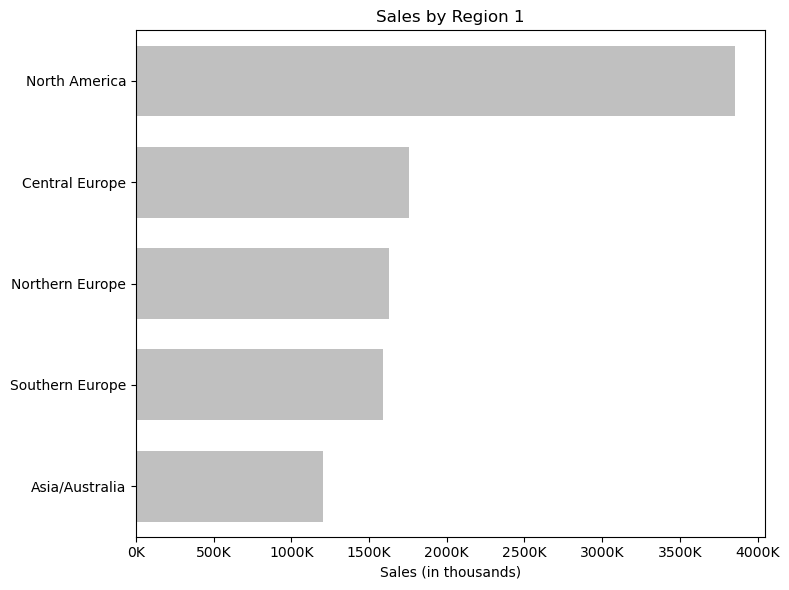

In [32]:
#sales barchart by region 1 

bar_width = 0.7

plt.figure(figsize=(8, 6))
sns.barplot(y="REGION1", x="SALES", data=df_sales_by_region1,  color="silver", width=bar_width)

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_thousands))
plt.xlabel("Sales (in thousands)")
plt.ylabel("")
plt.title("Sales by Region 1")
plt.tight_layout()

plt.show()

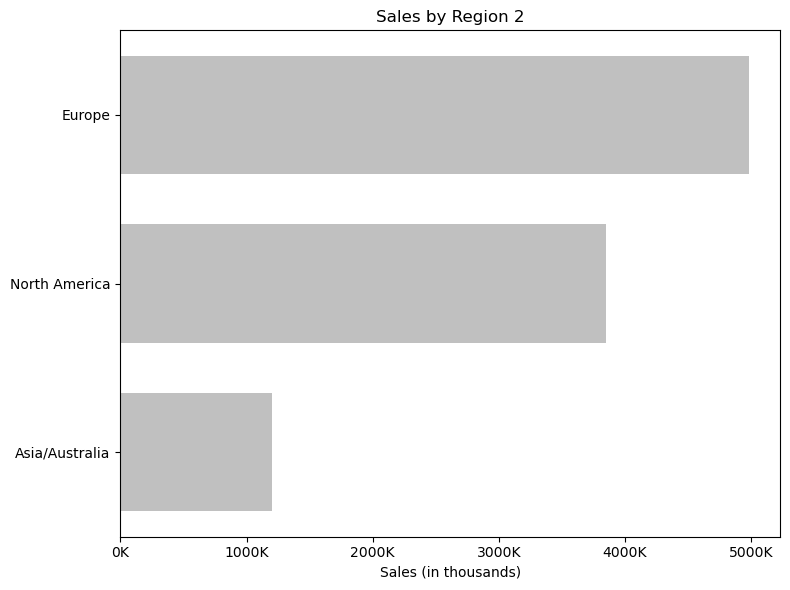

In [33]:
#sales barchart by region 2 

bar_width = 0.7

plt.figure(figsize=(8, 6))
sns.barplot(y="REGION2", x="SALES", data=df_sales_by_region2,  color="silver",width=bar_width)

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_thousands))
plt.xlabel("Sales (in thousands)")
plt.ylabel("")
plt.title("Sales by Region 2")
plt.tight_layout()

plt.show()

In [34]:
# orders by status
sales_by_status = sales_by(df,by = "status")
sales_by_status

,STATUS,SALES,PERCENTAGE
0,Shipped,9291501.08,92.61
1,Cancelled,194487.48,1.94
2,On Hold,178979.19,1.78
3,Resolved,150718.28,1.50
4,In Process,144729.96,1.44
5,Disputed,72212.86,0.72


In [35]:
# total amount of orders by year and status 
df.groupby(['YEAR_ID','STATUS']).count()['SALES']

YEAR_ID  STATUS    
2003     Cancelled       16
         Resolved         8
         Shipped        976
2004     Cancelled       44
         On Hold          6
         Resolved         8
         Shipped       1287
2005     Disputed        14
         In Process      41
         On Hold         38
         Resolved        31
         Shipped        354
Name: SALES, dtype: int64

# -----------------

# Sales perfomrance analysis 2003 - 2004

In [36]:
# Main KPIs comparation 

#calculation KPIs 
year2003 = table_MainKPIs(df, year_kpi=2003)
year2004 = table_MainKPIs(df,year_kpi=2004)

#comaration 
perf_trans(year2004,year2003,col = "KPI name")

,KPI NAME,KPI VALUE (2004),KPI VALUE (2003),Var absolute,Var relative(%)
0,Total Sales,4724162.60,3516979.54,1207183.06,34.32
1,Total Sales(shipped),4528047.22,3439718.03,1088329.19,31.64
2,Sales diff(%),4.33,2.25,2.08,92.44
3,Total quantity,46824.00,34612.00,12212.00,35.28
4,Total quantity(shipped),44866.00,33774.00,11092.00,32.84
5,Quantity diff(%),4.36,2.48,1.88,75.81
6,Average price per unit,100.89,101.61,-0.72,-0.71
7,Number of orders,1345.00,1000.00,345.00,34.50
8,Level of successful delivery (%),95.69,97.60,-1.91,-1.96
9,Cancelled orders(%),3.27,1.60,1.67,104.38


In [37]:
#filtering the database 2003/2004
df_analysis = df[(df["YEAR_ID"] == 2003) | (df["YEAR_ID"] == 2004)]
df_analysis = df_analysis.drop("ORDERDATE", axis = 1)

grouped_data = df_analysis.groupby(["YEAR_ID","MONTH_ID"]).sum()['SALES'].reset_index()

grouped_data2 = df_analysis.groupby(["YEAR_ID","MONTH_ID"]).count()['SALES'].reset_index()

grouped_data["NUMBER_ORDERS"] = grouped_data2["SALES"] 


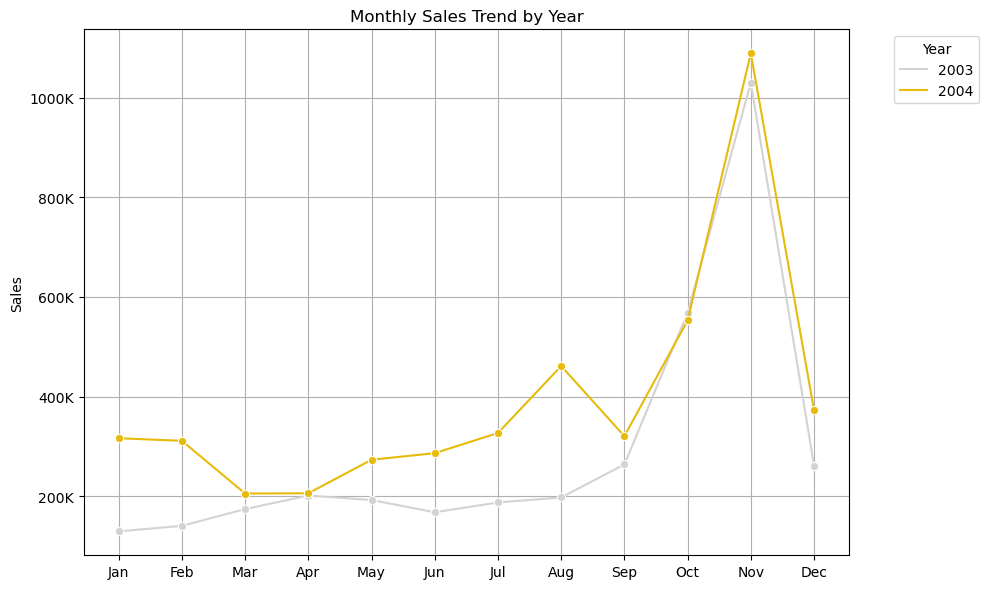

In [38]:
#graph trend line for selected years 
custom_palette = ["lightgrey","#E7BB0B"]

plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped_data, x="MONTH_ID", y="SALES", hue="YEAR_ID", marker='o', palette=custom_palette)

# Show the legend with combined colors for each "YEAR_ID"
plt.legend(title='Year', loc='upper left', bbox_to_anchor=(1.05, 1))


plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_thousands))
plt.xlabel("")
plt.ylabel("Sales")
plt.title("Monthly Sales Trend by Year")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.grid(True)
plt.tight_layout()

output_file = "sales_by_trend.pdf"
plt.savefig(output_file, format="pdf")

In [39]:
#sales by product line 
sales2003_pl = sales_by(df,by = "productline",year = 2003, rel = False)
sales2004_pl = sales_by(df,by ="productline", year = 2004, rel = False)

sales_pl = perf_trans(sales2004_pl,sales2003_pl, col = "productline")
sales_pl.sort_values("Var relative(%)", ascending= False)

,PRODUCTLINE,Sales(2004),Sales(2003),Var absolute,Var relative(%)
4,Planes,502671.80,272257.60,230414.20,84.63
6,Trains,116523.85,72802.29,43721.56,60.06
2,Motorcycles,560545.23,370895.58,189649.65,51.13
1,Vintage Cars,911423.77,650987.76,260436.01,40.01
5,Ships,341437.97,244821.09,96616.88,39.46
3,Trucks and Buses,529302.89,420429.93,108872.96,25.90
0,Classic Cars,1762257.09,1484785.29,277471.80,18.69


Text(0, 0.5, 'Sales (in thousands)')

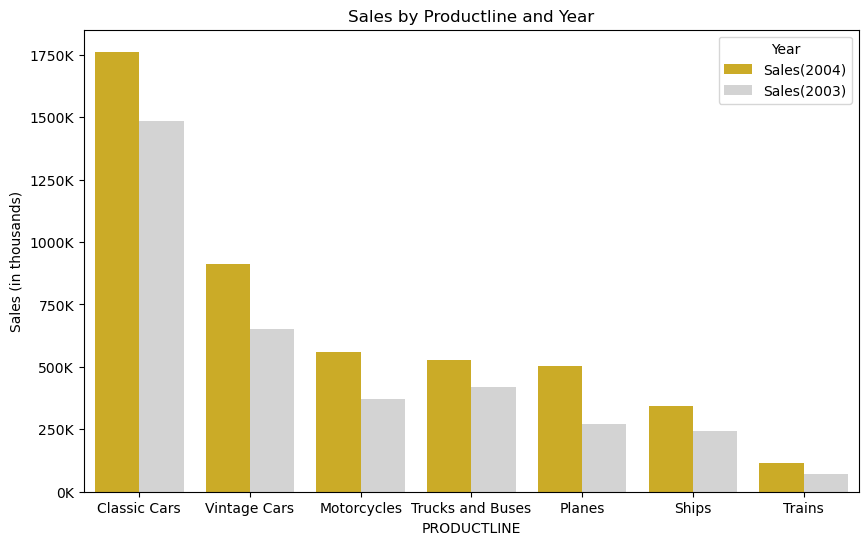

In [40]:
#graph sales by producline 

graph_data = sales_pl.iloc[:, [0,1,2]]
graph_data = graph_data.melt(id_vars = "PRODUCTLINE", var_name = "Year", value_name = "Sales")

custom_palette = ["#E7BB0B","lightgrey"]
plt.figure(figsize=(10, 6))
sns.barplot(data=graph_data, x='PRODUCTLINE', y='Sales', hue='Year', palette=custom_palette)

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_thousands))
plt.title("Sales by Productline and Year")
plt.ylabel("Sales (in thousands)")

In [41]:
#sales by country compare
sales2003_c = sales_by(df,by = "country",year = 2003, rel = False)
sales2004_c = sales_by(df,by = "country", year = 2004, rel = False)

sales2004_c = perf_trans(sales2004_c,sales2003_c, col = "country")
sales2004_c.sort_values("Var relative(%)", ascending= False).reset_index(drop = True)

,COUNTRY,Sales(2004),Sales(2003),Var absolute,Var relative(%)
0,Belgium,80024.05,3348.46,76675.59,2289.88
1,Canada,135776.09,54609.50,81166.59,148.63
2,Germany,150418.78,70053.31,80365.47,114.72
3,Sweden,119947.57,58459.92,61487.65,105.18
4,France,555198.70,312761.42,242437.28,77.52
5,UK,257656.10,180421.55,77234.55,42.81
6,Italy,192235.60,140928.77,51306.83,36.41
7,USA,1685470.69,1305147.88,380322.81,29.14
8,Denmark,120431.56,99192.72,21238.84,21.41
9,Spain,483545.36,405343.39,78201.97,19.29


In [42]:
#sales by region1 compare 
sales2003_c = sales_by(df,by = "region1",year = 2003, rel = False)
sales2004_c = sales_by(df,by = "region1", year = 2004, rel = False)

sales2004_c = perf_trans(sales2004_c,sales2003_c, col = "region1")
sales2004_c.sort_values("Var relative(%)", ascending= False)


,REGION1,Sales(2004),Sales(2003),Var absolute,Var relative(%)
1,Central Europe,955049.48,468281.07,486768.41,103.95
0,North America,1821246.78,1359757.38,461489.40,33.94
3,Southern Europe,675780.96,546272.16,129508.80,23.71
2,Northern Europe,758298.45,645761.30,112537.15,17.43
4,Asia/Australia,513786.93,496907.63,16879.30,3.40


In [43]:
#sales by size 
sales2003_d = sales_by(df,by = "dealsize",year = 2003, rel = False)
sales2004_d = sales_by(df,by = "dealsize", year = 2004, rel = False)
sales2004_d
sales2004_d = perf_trans(sales2004_d,sales2003_d, col = "dealsize")
sales2004_d.sort_values("Var relative(%)", ascending= False)


,DEALSIZE,Sales(2004),Sales(2003),Var absolute,Var relative(%)
1,Small,1337051.01,905447.86,431603.15,47.67
0,Medium,2869357.88,2178711.74,690646.14,31.70
2,Large,517753.71,432819.94,84933.77,19.62


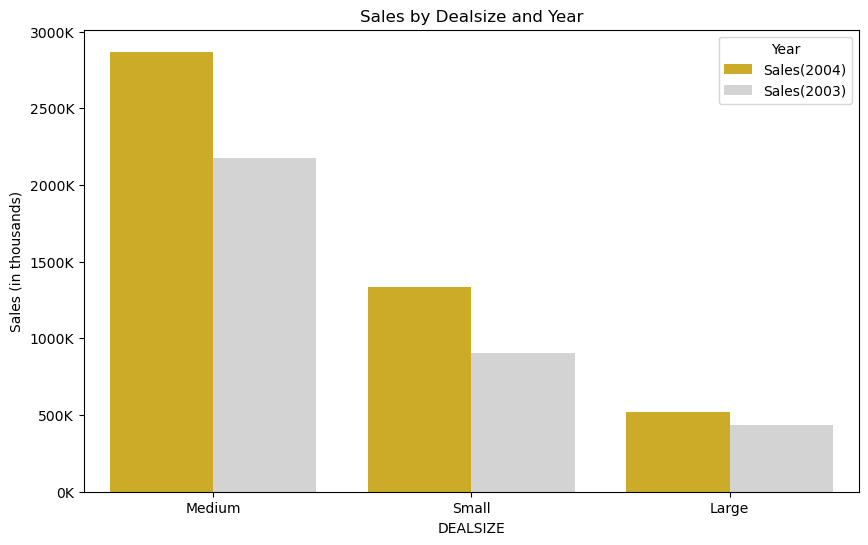

In [87]:
#sales vy dealsize and year 
graph_data_size = sales2004_d.iloc[:, [0,1,2]]
graph_data_size = graph_data_size.melt(id_vars = "DEALSIZE", var_name = "Year", value_name = "Sales")

custom_palette = ["#E7BB0B","lightgrey"]
plt.figure(figsize=(10, 6))
sns.barplot(data=graph_data_size, x='DEALSIZE', y='Sales', hue='Year', palette=custom_palette)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_thousands))
plt.title("Sales by Dealsize and Year")
plt.ylabel("Sales (in thousands)")

plt.show()


In [45]:
#info about not shipped orders
df_analysis.groupby(['YEAR_ID','STATUS']).count()['SALES']

YEAR_ID  STATUS   
2003     Cancelled      16
         Resolved        8
         Shipped       976
2004     Cancelled      44
         On Hold         6
         Resolved        8
         Shipped      1287
Name: SALES, dtype: int64

In [46]:
# Cancelled orders by country and year 
df_can_conuntry = df.loc[df['STATUS'] == 'Cancelled']
df_can_conuntry = df_can_conuntry.groupby(['YEAR_ID','COUNTRY']).count()['STATUS'].reset_index()
df_can_conuntry = df_can_conuntry.rename(columns = {'STATUS':'CANCELLED AMOUNT'})
df_can_conuntry

,YEAR_ID,COUNTRY,CANCELLED AMOUNT
0,2003,Sweden,16
1,2004,Spain,16
2,2004,UK,14
3,2004,USA,14


In [47]:
#information about cancelled orders in 2003 
df.loc[(df['YEAR_ID'] == 2003) & (df['STATUS'] == 'Cancelled')]

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,CUSTOMERNAME,CITY,COUNTRY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE,REGION1,REGION2
111,10167,44,100.00,5924.16,10/23/2003 0:00,Cancelled,4,10,2003,Classic Cars,Scandinavian Gift Ideas,Boras,Sweden,Larsson,Maria,Medium,Northern Europe,Europe
557,10167,43,100.00,5763.72,10/23/2003 0:00,Cancelled,4,10,2003,Planes,Scandinavian Gift Ideas,Boras,Sweden,Larsson,Maria,Medium,Northern Europe,Europe
940,10167,46,73.12,3363.52,10/23/2003 0:00,Cancelled,4,10,2003,Ships,Scandinavian Gift Ideas,Boras,Sweden,Larsson,Maria,Medium,Northern Europe,Europe
1220,10167,34,100.00,3599.58,10/23/2003 0:00,Cancelled,4,10,2003,Vintage Cars,Scandinavian Gift Ideas,Boras,Sweden,Larsson,Maria,Medium,Northern Europe,Europe
1595,10167,33,100.00,3812.16,10/23/2003 0:00,Cancelled,4,10,2003,Ships,Scandinavian Gift Ideas,Boras,Sweden,Larsson,Maria,Medium,Northern Europe,Europe
1749,10167,21,69.88,1467.48,10/23/2003 0:00,Cancelled,4,10,2003,Planes,Scandinavian Gift Ideas,Boras,Sweden,Larsson,Maria,Small,Northern Europe,Europe
1824,10167,20,79.66,1593.20,10/23/2003 0:00,Cancelled,4,10,2003,Vintage Cars,Scandinavian Gift Ideas,Boras,Sweden,Larsson,Maria,Small,Northern Europe,Europe
1899,10167,32,63.12,2019.84,10/23/2003 0:00,Cancelled,4,10,2003,Vintage Cars,Scandinavian Gift Ideas,Boras,Sweden,Larsson,Maria,Small,Northern Europe,Europe
1949,10167,29,83.86,2431.94,10/23/2003 0:00,Cancelled,4,10,2003,Vintage Cars,Scandinavian Gift Ideas,Boras,Sweden,Larsson,Maria,Small,Northern Europe,Europe
2462,10167,43,75.34,3239.62,10/23/2003 0:00,Cancelled,4,10,2003,Ships,Scandinavian Gift Ideas,Boras,Sweden,Larsson,Maria,Medium,Northern Europe,Europe


In [48]:
#information about resolved orders in 2003 
df.loc[(df['YEAR_ID'] == 2003) & (df['STATUS'] == 'Resolved')]

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,CUSTOMERNAME,CITY,COUNTRY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE,REGION1,REGION2
138,10164,21,100.00,3536.82,10/21/2003 0:00,Resolved,4,10,2003,Classic Cars,Mini Auto Werke,Graz,Austria,Mendel,Roland,Medium,Central Europe,Europe
217,10164,49,100.00,6563.06,10/21/2003 0:00,Resolved,4,10,2003,Trucks and Buses,Mini Auto Werke,Graz,Austria,Mendel,Roland,Medium,Central Europe,Europe
425,10164,36,99.17,3570.12,10/21/2003 0:00,Resolved,4,10,2003,Trucks and Buses,Mini Auto Werke,Graz,Austria,Mendel,Roland,Medium,Central Europe,Europe
1320,10164,45,100.00,5012.55,10/21/2003 0:00,Resolved,4,10,2003,Trucks and Buses,Mini Auto Werke,Graz,Austria,Mendel,Roland,Medium,Central Europe,Europe
1347,10164,25,53.83,1345.75,10/21/2003 0:00,Resolved,4,10,2003,Vintage Cars,Mini Auto Werke,Graz,Austria,Mendel,Roland,Small,Central Europe,Europe
2151,10164,24,100.00,2634.96,10/21/2003 0:00,Resolved,4,10,2003,Trucks and Buses,Mini Auto Werke,Graz,Austria,Mendel,Roland,Small,Central Europe,Europe
2281,10164,49,54.94,2692.06,10/21/2003 0:00,Resolved,4,10,2003,Trucks and Buses,Mini Auto Werke,Graz,Austria,Mendel,Roland,Small,Central Europe,Europe
2619,10164,39,81.93,3195.27,10/21/2003 0:00,Resolved,4,10,2003,Classic Cars,Mini Auto Werke,Graz,Austria,Mendel,Roland,Medium,Central Europe,Europe


In [49]:
#information about cancelled orders in 2004
df.loc[(df['YEAR_ID'] == 2004) & (df['STATUS'] == 'Cancelled')].sort_values(by = "COUNTRY")

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,CUSTOMERNAME,CITY,COUNTRY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE,REGION1,REGION2
1756,10262,24,67.14,1611.36,6/24/2004 0:00,Cancelled,2,6,2004,Planes,Euro Shopping Channel,Madrid,Spain,Freyre,Diego,Small,Southern Europe,Europe
2363,10262,49,37.97,1860.53,6/24/2004 0:00,Cancelled,2,6,2004,Vintage Cars,Euro Shopping Channel,Madrid,Spain,Freyre,Diego,Small,Southern Europe,Europe
2312,10262,40,79.11,3164.40,6/24/2004 0:00,Cancelled,2,6,2004,Vintage Cars,Euro Shopping Channel,Madrid,Spain,Freyre,Diego,Medium,Southern Europe,Europe
2009,10262,48,61.42,2948.16,6/24/2004 0:00,Cancelled,2,6,2004,Planes,Euro Shopping Channel,Madrid,Spain,Freyre,Diego,Small,Southern Europe,Europe
1956,10262,49,87.21,4273.29,6/24/2004 0:00,Cancelled,2,6,2004,Vintage Cars,Euro Shopping Channel,Madrid,Spain,Freyre,Diego,Medium,Southern Europe,Europe
2546,10262,44,94.14,4142.16,6/24/2004 0:00,Cancelled,2,6,2004,Ships,Euro Shopping Channel,Madrid,Spain,Freyre,Diego,Medium,Southern Europe,Europe
1906,10262,46,70.35,3236.10,6/24/2004 0:00,Cancelled,2,6,2004,Vintage Cars,Euro Shopping Channel,Madrid,Spain,Freyre,Diego,Medium,Southern Europe,Europe
2573,10262,33,90.75,2994.75,6/24/2004 0:00,Cancelled,2,6,2004,Planes,Euro Shopping Channel,Madrid,Spain,Freyre,Diego,Small,Southern Europe,Europe
2782,10262,21,57.11,1199.31,6/24/2004 0:00,Cancelled,2,6,2004,Planes,Euro Shopping Channel,Madrid,Spain,Freyre,Diego,Small,Southern Europe,Europe
1525,10262,34,97.38,3310.92,6/24/2004 0:00,Cancelled,2,6,2004,Planes,Euro Shopping Channel,Madrid,Spain,Freyre,Diego,Medium,Southern Europe,Europe


In [50]:
#information about on hold orders in 2004
df.loc[(df['YEAR_ID'] == 2004) & (df['STATUS'] == 'On Hold')].sort_values(by = "COUNTRY")

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,CUSTOMERNAME,CITY,COUNTRY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE,REGION1,REGION2
153,10334,26,100.00,3188.12,11/19/2004 0:00,On Hold,4,11,2004,Classic Cars,"Volvo Model Replicas, Co",Lule,Sweden,Berglund,Christina,Medium,Northern Europe,Europe
721,10334,46,100.00,5814.86,11/19/2004 0:00,On Hold,4,11,2004,Trucks and Buses,"Volvo Model Replicas, Co",Lule,Sweden,Berglund,Christina,Medium,Northern Europe,Europe
773,10334,34,61.38,2086.92,11/19/2004 0:00,On Hold,4,11,2004,Trucks and Buses,"Volvo Model Replicas, Co",Lule,Sweden,Berglund,Christina,Small,Northern Europe,Europe
1052,10334,20,100.00,2878.80,11/19/2004 0:00,On Hold,4,11,2004,Classic Cars,"Volvo Model Replicas, Co",Lule,Sweden,Berglund,Christina,Small,Northern Europe,Europe
1335,10334,49,100.00,6763.47,11/19/2004 0:00,On Hold,4,11,2004,Trucks and Buses,"Volvo Model Replicas, Co",Lule,Sweden,Berglund,Christina,Medium,Northern Europe,Europe
1661,10334,42,100.00,5528.04,11/19/2004 0:00,On Hold,4,11,2004,Trucks and Buses,"Volvo Model Replicas, Co",Lule,Sweden,Berglund,Christina,Medium,Northern Europe,Europe


In [51]:
#information about resolved orders in 2004
df.loc[(df['YEAR_ID'] == 2004) & (df['STATUS'] == 'Resolved')].sort_values(by = "COUNTRY")

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,CUSTOMERNAME,CITY,COUNTRY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE,REGION1,REGION2
570,10327,25,100.00,2804.75,11/10/2004 0:00,Resolved,4,11,2004,Planes,Danish Wholesale Imports,Kobenhavn,Denmark,Petersen,Jytte,Small,Northern Europe,Europe
796,10327,45,100.00,4781.70,11/10/2004 0:00,Resolved,4,11,2004,Planes,Danish Wholesale Imports,Kobenhavn,Denmark,Petersen,Jytte,Medium,Northern Europe,Europe
953,10327,25,45.86,1146.50,11/10/2004 0:00,Resolved,4,11,2004,Ships,Danish Wholesale Imports,Kobenhavn,Denmark,Petersen,Jytte,Small,Northern Europe,Europe
2527,10327,20,100.00,3469.20,11/10/2004 0:00,Resolved,4,11,2004,Ships,Danish Wholesale Imports,Kobenhavn,Denmark,Petersen,Jytte,Medium,Northern Europe,Europe
2607,10327,21,96.31,2022.51,11/10/2004 0:00,Resolved,4,11,2004,Ships,Danish Wholesale Imports,Kobenhavn,Denmark,Petersen,Jytte,Small,Northern Europe,Europe
2710,10327,43,80.00,3440.00,11/10/2004 0:00,Resolved,4,11,2004,Ships,Danish Wholesale Imports,Kobenhavn,Denmark,Petersen,Jytte,Medium,Northern Europe,Europe
2736,10327,37,86.61,3204.57,11/10/2004 0:00,Resolved,4,11,2004,Ships,Danish Wholesale Imports,Kobenhavn,Denmark,Petersen,Jytte,Medium,Northern Europe,Europe
2816,10327,37,86.74,3209.38,11/10/2004 0:00,Resolved,4,11,2004,Ships,Danish Wholesale Imports,Kobenhavn,Denmark,Petersen,Jytte,Medium,Northern Europe,Europe


# -----------------

## Customers Overview

In [52]:
#total amount of unique customers 
len(df["CUSTOMERNAME"].unique())

92

Number of unique customers by year:

In [53]:
#unique customers in 2003 
df_2003 = df[df['YEAR_ID'] == 2003]
n_2003 = len(df_2003["CUSTOMERNAME"].unique())
n_2003

69

In [54]:
#unique customers in 2004 
df_2004 = df[df['YEAR_ID'] == 2004]
n_2004 = len(df_2004["CUSTOMERNAME"].unique())
n_2004

84

In [55]:
#unique customers in 2005 
df_2005 = df[df['YEAR_ID'] == 2005]
n_2005 = len(df_2005["CUSTOMERNAME"].unique())
n_2005 

40

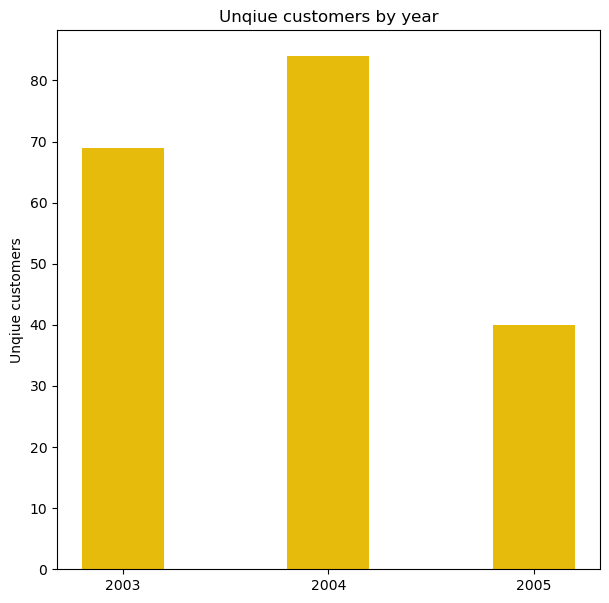

In [56]:
#unique customers barchart 
time_line = pd.Categorical([2003,2004,2005])
values_time = [n_2003,n_2004,n_2005]


plt.figure(figsize=(7, 7))
plt.bar(time_line, values_time, color=["#E7BB0B"], width = 0.4)
plt.xticks(time_line, time_line.categories)

plt.title('Unqiue customers by year')
plt.ylabel('Unqiue customers')
plt.show()

Comparing years 2003 and 2004 by unique customers

In [57]:
#list of customers in 2003 
customers_2003 = df_2003['CUSTOMERNAME']
#list of customers in 2004
customers_2004 = df_2004['CUSTOMERNAME']

#find customers who had orders in 2004 but not in 2003 
new_customers_2004 = customers_2004[~customers_2004.isin(customers_2003)]

#number of unique new customers who ordered in 2004 but not in 2003 (customers who came to order in 2004)
num_new_customers_2004 = new_customers_2004.nunique()
num_new_customers_2004

#number of unique customers who ordered in 2003 but not in 2004 
old_customers_2003 = customers_2003[~customers_2003.isin(customers_2004)]
num_old_customers_2003 = old_customers_2003.nunique()

Top 5 customers by sales 

In [58]:
top_customer = df.groupby("CUSTOMERNAME").sum().sort_values("SALES", ascending = False).head(5)
top_customer = top_customer[["SALES"]]
top_customer.reset_index(inplace = True) 
top_customer.head()

,CUSTOMERNAME,SALES
0,Euro Shopping Channel,912294.11
1,Mini Gifts Distributors Ltd.,654858.06
2,"Australian Collectors, Co.",200995.41
3,Muscle Machine Inc,197736.94
4,La Rochelle Gifts,180124.90


# -----------------

##  Cluster segmentation and analysis 

In the next part of this project, the focus will shift to Cluster segmentation and its analysis.

As presented data represents panel data (for one customer there is more than one record overtime time), for simplicity of this project data will be aggregated in meaningful measure that will represent customer behaviour:

For these purposes **Recency** (represents the most recent activity of a customer), **Frequency** (represents the overall level of customer activity) and **Monetary** (represents customer activity by monetary value).

## Calculating R,F,M 

- Recency(days): How recently has the customer made a transaction with us
- Frequency(units): How frequent is the customer in ordering/buying some product from us
- Monetary($): How much does the customer spend on purchasing products from us.

In [59]:
#converting ORDERDATE to pandas Datetime form
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])

In [60]:
#current data (the max value of the orderdate column)
now = max(df['ORDERDATE'])

In [61]:
#calculating r, f, m 
RFM = df.groupby('CUSTOMERNAME').agg({'ORDERDATE': lambda x: (now - x.max()).days, # Recency
                                                'ORDERNUMBER': lambda x: len(x.unique()), # Frequency
                                                'SALES': lambda x: x.sum()}).reset_index()    # Monetary 

In [62]:
#checking data types
RFM.dtypes

CUSTOMERNAME     object
ORDERDATE         int64
ORDERNUMBER       int64
SALES           float64
dtype: object

In [63]:
RFM.rename(columns={'ORDERDATE': 'Recency', 
                         'ORDERNUMBER': 'Frequency',
                         'SALES': 'Monetary_value'}, inplace=True)

Calculating extra variables for analysis:    
    
* Productline (count for each values)

* Dealsize (count for each values)

Retaining all values might not be the optimal approach, as it would lead to a perfect correlation between certain variables. Summing the values by rows for product lines would equal to the sum of deal sizes as it totals up to overall number of orders for each customer. 

As demonstrated later, dealsize variables exhibit a high correlation with monetary value. Consequently, for the analysis, it is excluded from final df.

In [64]:
#unpivot productline column
df_productline = df.groupby('CUSTOMERNAME')['PRODUCTLINE'].value_counts().unstack(fill_value=0).reset_index()

#unpivot dealsize column
df_dealsize = df.groupby('CUSTOMERNAME')['DEALSIZE'].value_counts().unstack(fill_value=0).reset_index()

#droping one of the variable because it will create a perfect correlation

In [65]:
#joining tables
clusters = RFM.merge(df_productline, on='CUSTOMERNAME', how='left')
df_cluster = clusters.merge(df_dealsize, on='CUSTOMERNAME', how='left')

In [66]:
df_cluster

,CUSTOMERNAME,Recency,Frequency,Monetary_value,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,"AV Stores, Co.",195,3,157807.81,19,0,0,7,3,0,22,1,25,25
1,Alpha Cognac,64,3,70488.44,4,0,6,7,0,0,3,1,10,9
2,Amica Models & Co.,264,2,94117.26,4,0,0,3,1,1,17,3,10,13
3,"Anna's Decorations, Ltd",83,4,153996.13,24,6,0,0,0,9,7,2,20,24
4,Atelier graphique,187,3,24179.96,4,2,0,0,0,0,1,0,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,"Vida Sport, Ltd",274,2,117713.56,31,0,0,0,0,0,0,0,22,9
88,Vitachrome Inc.,207,3,88041.26,7,9,0,0,0,5,4,3,10,12
89,"Volvo Model Replicas, Co",193,4,75754.88,8,0,0,2,1,4,4,1,11,7
90,West Coast Collectables Co.,488,2,46084.64,1,0,2,0,0,1,9,0,8,5


## K-means clustering 

Brief EDA 

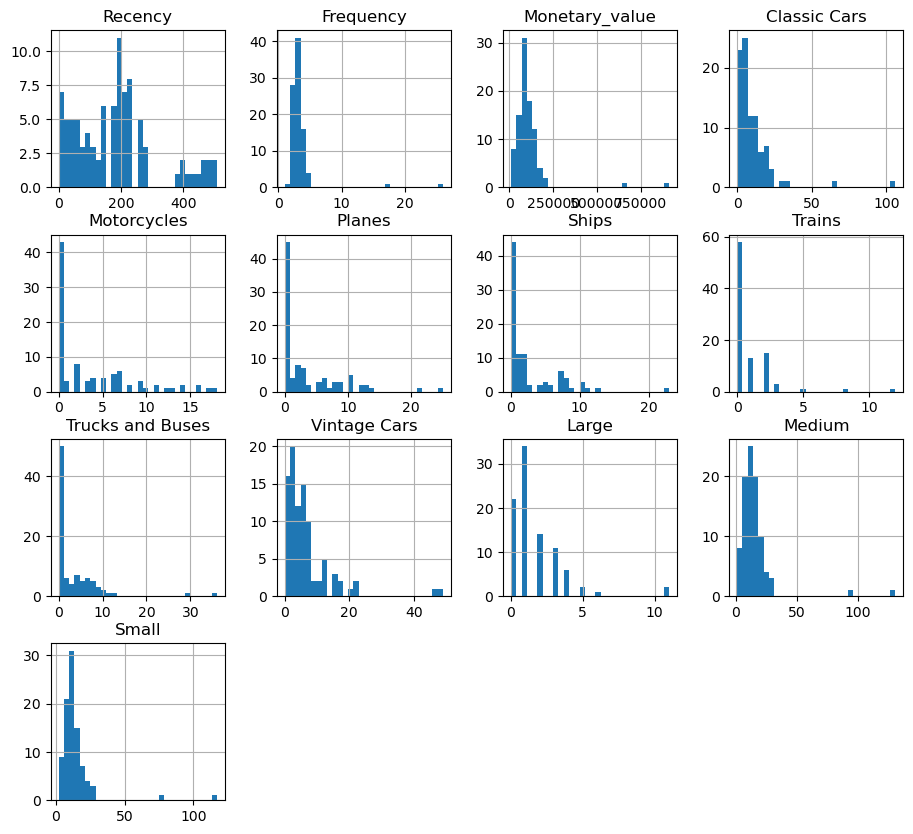

In [67]:
#histogram of all variables 
df_cluster.hist(bins = 30, figsize = (11,10))
plt.show()

There are 2 clear outliers (top 2 customers):

In [68]:
df_cluster[(df_cluster["CUSTOMERNAME"] == "Euro Shopping Channel") | (df_cluster["CUSTOMERNAME"] == "Mini Gifts Distributors Ltd.")]

,CUSTOMERNAME,Recency,Frequency,Monetary_value,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
33,Euro Shopping Channel,0,26,912294.11,106,17,25,23,12,29,47,11,131,117
55,Mini Gifts Distributors Ltd.,2,17,654858.06,67,10,0,10,8,36,49,11,92,77


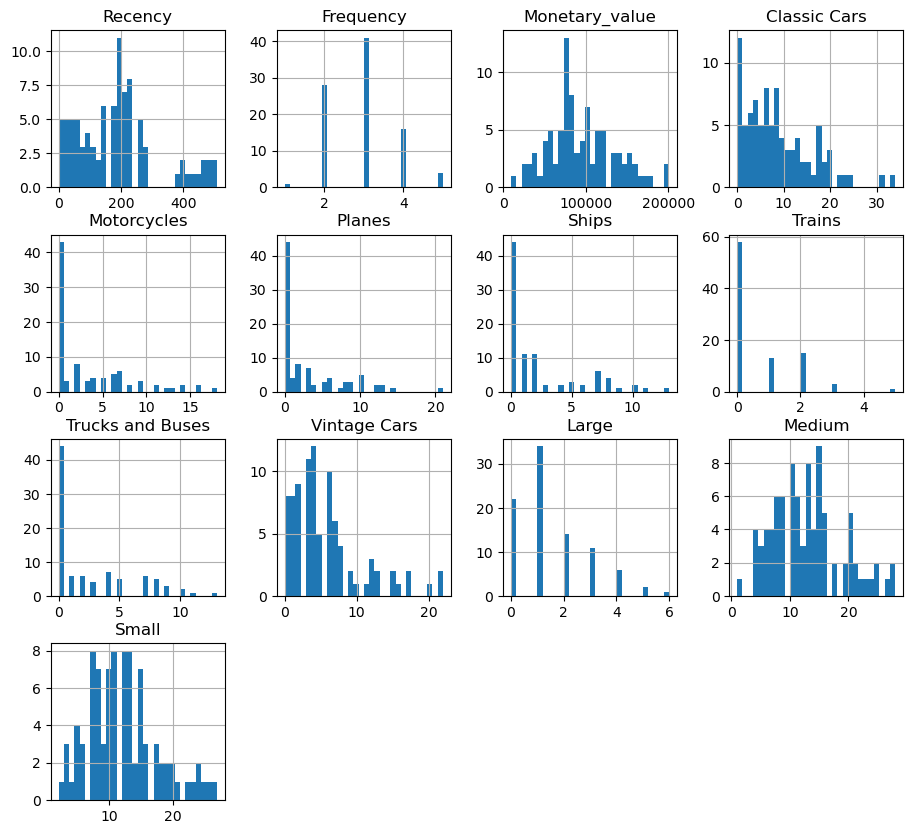

In [69]:
#getting rid of outliers 
df_cluster_fix = df_cluster.drop([33,55])

df_cluster_fix.hist(bins = 30, figsize = (11,10))
plt.show()

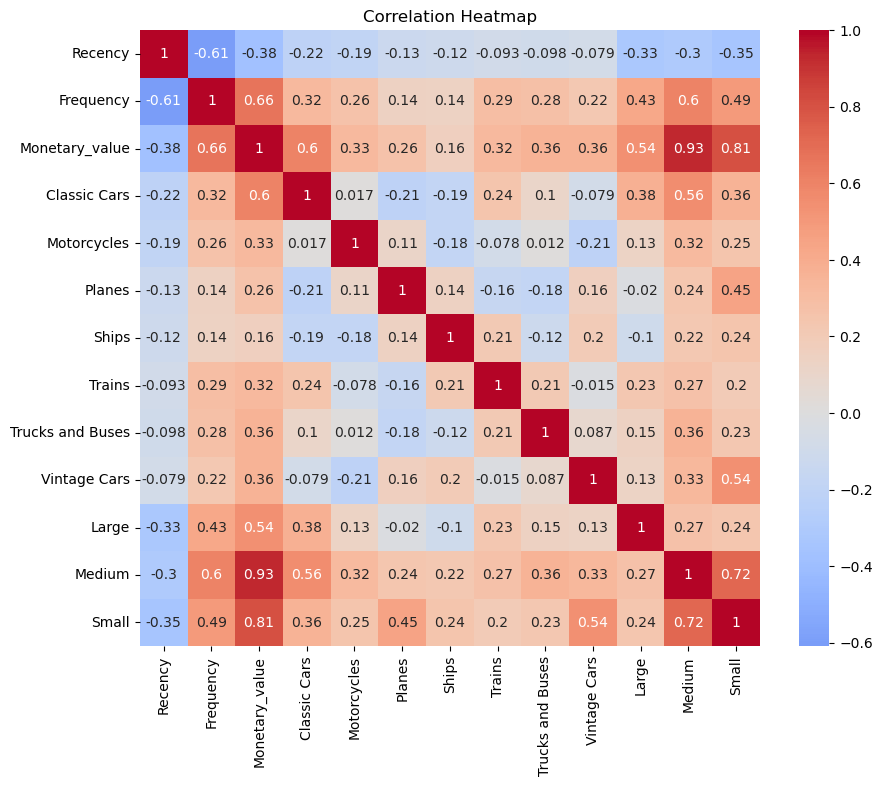

In [70]:
# correlation matrix
corr = df_cluster_fix.drop(["CUSTOMERNAME"], axis = 1).corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()


All dealsize categories are in high correlation with monetary value and with each other. These variables will be excluded from the analysis

In [71]:
df_cluster_fix = df_cluster_fix.drop(["Large","Medium","Small"], axis = 1)

## K-means clustering 

In [72]:
#setting customername column as indexes 
df_cluster_fix.set_index("CUSTOMERNAME", inplace = True)

In [73]:
#scaling data
normalized_df_cluster = (df_cluster_fix - df_cluster_fix.mean())/df_cluster_fix.std()

In [74]:
def ellbow_plot(data,k): 
    
    #getting data
    means = []
    inertias = []
    
    for k in range(1, k):
        #fitting the model for k 
        kmeans = KMeans(k, init='k-means++')
        kmeans.fit(data)
        
        means.append(k)
        inertias.append(kmeans.inertia_)
    
    #plotting the ellbow graph 

    plt.figure(figsize=(10, 6))
    plt.plot(means, inertias, marker='o', linestyle='-', color='black')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.grid(True)

    # Set the number of steps on x-axis to 1
    plt.xticks(range(min(means), max(means)+1, 1))
    plt.show()

/Users/vladimir/miniconda3/envs/minimal_ds/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/vladimir/miniconda3/envs/minimal_ds/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/vladimir/miniconda3/envs/minimal_ds/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/vladimir/miniconda3/envs/minimal_ds/lib/python3.11/site-packages/sklearn/cluster/

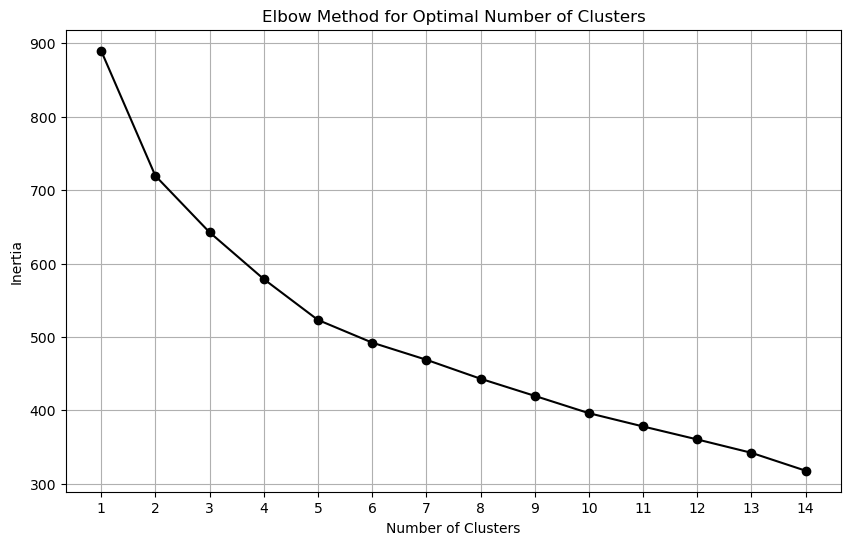

In [75]:
ellbow_plot(normalized_df_cluster,15)

Ellbow plot show the optimal number of clusters between 4-6. For this analysis, let's choose 4 

In [76]:
#fitting the model 
means = 4 
kmeans = KMeans(means,init='k-means++',random_state=0)
kmeans.fit(normalized_df_cluster)

/Users/vladimir/miniconda3/envs/minimal_ds/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=4, random_state=0)

In [77]:
#lables for variables 
labels = list(normalized_df_cluster.columns.values)

#centroids
centroids = kmeans.cluster_centers_
centroids = pd.DataFrame(centroids, columns = labels).T
centroids

,0,1,2,3
Recency,-0.795892,1.030481,-0.259482,-0.247730
Frequency,1.400984,-1.009451,0.038072,0.016603
Monetary_value,1.397323,-0.978266,-0.082268,0.162522
Classic Cars,0.643789,-0.687650,0.479616,-0.403265
Motorcycles,0.656626,-0.339391,0.297145,-0.594477
Planes,0.561009,-0.036905,-0.412195,0.175744
Ships,-0.090667,-0.333097,-0.586076,1.413945
Trains,0.543443,-0.313510,-0.116157,0.103567
Trucks and Buses,0.854095,-0.206304,-0.294237,-0.043639
Vintage Cars,0.366343,-0.387343,-0.413814,0.813493


In [78]:
def plot_kmeans_clusters(data, means):
    
     # Apply PCA to reduce dimensions to 2
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)
        
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=means, init='k-means++')
    clusters = kmeans.fit_predict(reduced_data)
        
    # Plot the clusters using PCA-reduced data
    plt.figure(figsize=(10, 6))
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='rainbow')
    plt.title(f'K-Means Clustering with {means} Clusters')
    plt.xlabel('')
    plt.ylabel('')

    plt.show()

/Users/vladimir/miniconda3/envs/minimal_ds/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


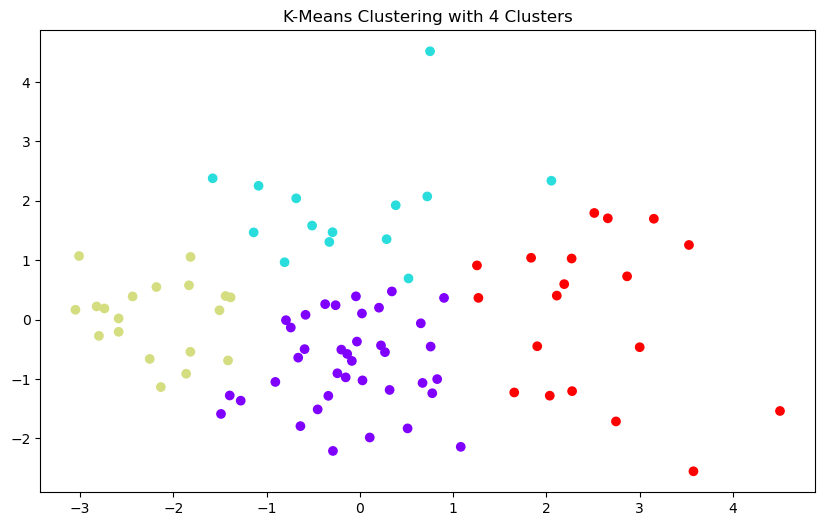

In [79]:
plot_kmeans_clusters(normalized_df_cluster, means)

## Cluster analysis 

In [80]:
#renaming labels 
custom_name = {0: "Loyal", 1: "About to lose", 2:"Need attention", 3:"Stable"}
result= list(kmeans.labels_)
resuls_custom = [custom_name[i] for i in result]

custom_order = ['Loyal', 'Stable', 'Need attention', 'About to lose']

# Create a Categorical object with custom order
resuls_custom  = pd.Categorical(resuls_custom, categories=custom_order, ordered=True)

In [81]:
df_cluster_output = df_cluster_fix.reset_index().copy()
df_cluster_output["Cluster"] = resuls_custom
df_cluster_output

,CUSTOMERNAME,Recency,Frequency,Monetary_value,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Cluster
0,"AV Stores, Co.",195,3,157807.81,19,0,0,7,3,0,22,Stable
1,Alpha Cognac,64,3,70488.44,4,0,6,7,0,0,3,Stable
2,Amica Models & Co.,264,2,94117.26,4,0,0,3,1,1,17,Stable
3,"Anna's Decorations, Ltd",83,4,153996.13,24,6,0,0,0,9,7,Loyal
4,Atelier graphique,187,3,24179.96,4,2,0,0,0,0,1,About to lose
...,...,...,...,...,...,...,...,...,...,...,...,...
85,"Vida Sport, Ltd",274,2,117713.56,31,0,0,0,0,0,0,Need attention
86,Vitachrome Inc.,207,3,88041.26,7,9,0,0,0,5,4,Need attention
87,"Volvo Model Replicas, Co",193,4,75754.88,8,0,0,2,1,4,4,Need attention
88,West Coast Collectables Co.,488,2,46084.64,1,0,2,0,0,1,9,About to lose


In [82]:
df_cluster_output.drop("CUSTOMERNAME",axis =1).groupby("Cluster").count()

,Recency,Frequency,Monetary_value,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars
Cluster,,,,,,,,,,
Loyal,17,17,17,17,17,17,17,17,17,17
Stable,19,19,19,19,19,19,19,19,19,19
Need attention,29,29,29,29,29,29,29,29,29,29
About to lose,25,25,25,25,25,25,25,25,25,25


In [83]:
round(df_cluster_output.drop("CUSTOMERNAME",axis =1).groupby("Cluster").mean(),2)

,Recency,Frequency,Monetary_value,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars
Cluster,,,,,,,,,,
Loyal,82.35,4.12,150258.88,13.41,6.35,5.59,1.94,1.18,5.53,7.53
Stable,153.63,2.95,100597.22,5.95,0.68,3.89,6.79,0.74,2.47,9.79
Need attention,152.10,2.97,90752.19,12.24,4.72,1.31,0.34,0.52,1.62,3.59
About to lose,319.84,2.08,54716.61,3.92,1.84,2.96,1.16,0.32,1.92,3.72


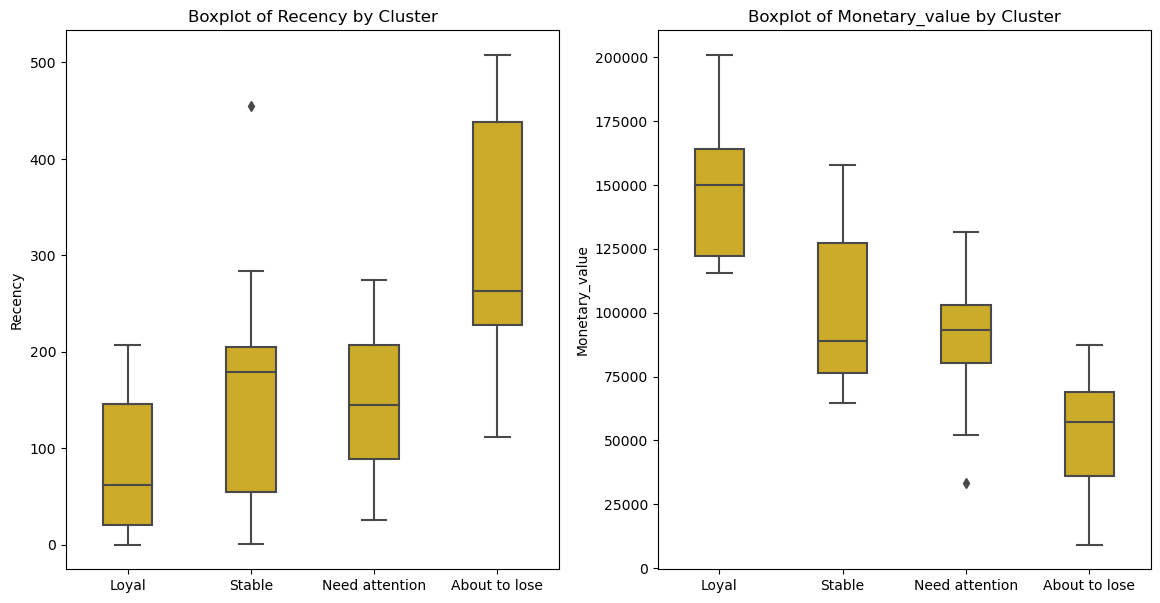

In [84]:
variables_to_plot = ['Recency', 'Monetary_value']

# Create subplots
num_rows = 1
num_cols = 2

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(14,7))
axes = axes.flatten()


# Iterate through variables and create boxplots
for i, variable in enumerate(variables_to_plot):
    sns.boxplot(data=df_cluster_output, x='Cluster', y=variable, hue='Cluster', ax=axes[i],dodge=False
                , width=0.4,palette=["#E7BB0B"])
    axes[i].set_xlabel('')
    axes[i].set_ylabel(variable)
    axes[i].get_legend().remove()
    axes[i].set_title(f'Boxplot of {variable} by Cluster')

plt.show()

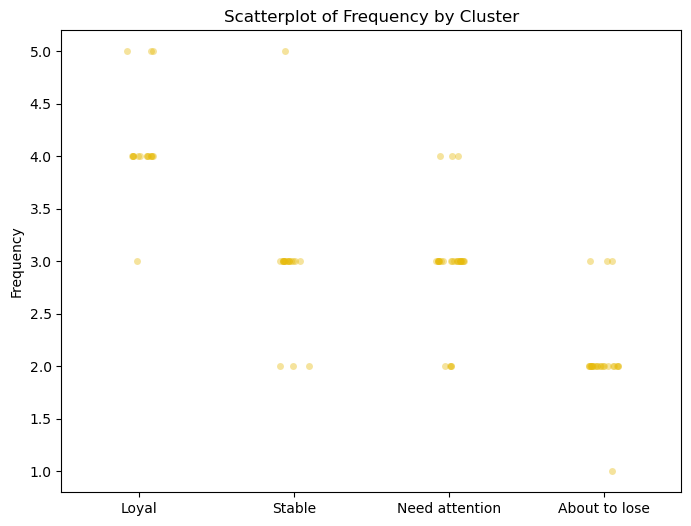

In [85]:
# Create a scatter plot
plt.figure(figsize=(8, 6))
sns.stripplot(x='Cluster', y='Frequency', data=df_cluster_output, color='#E7BB0B',jitter=True, alpha = 0.4)

# Customize the plot
plt.xlabel('')
plt.ylabel('Frequency')
plt.title('Scatterplot of Frequency by Cluster')
plt.show()

<Figure size 1000x1500 with 0 Axes>

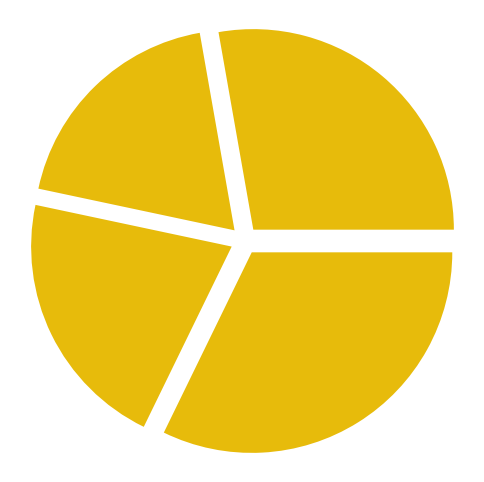

In [86]:
# creating pit chart 

plt.figure(figsize=(10, 15))

pit_chart = df_cluster_output.groupby("Cluster").count().reset_index()[["Cluster","CUSTOMERNAME"]]

explode = [0.07, 0.07, 0.07, 0.07]

plt.figure(figsize=(6, 6))
plt.pie(pit_chart['CUSTOMERNAME'], labels=pit_chart['Cluster'], startangle=100, colors=['#E7BB0B', '#E7BB0B', '#E7BB0B'], explode=explode,labeldistance=None)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('')
plt.show()